# EUR/GBP Bollinger Bands Walk-Forward Optimization

This notebook implements **Walk-Forward Optimization** for the EUR/GBP Bollinger Bands trading strategy, using the same tick-by-tick backtesting logic as the grid optimization version.

## Walk-Forward Optimization Overview

**Purpose**: Test the robustness of parameter optimization by simulating real-world trading conditions where:
- Parameters are optimized on historical data (training window)
- The optimized parameters are tested on future data (test window)
- This process is repeated over multiple time periods

**Key Benefits**:
- **Realistic**: Mimics actual trading where you can only optimize on past data
- **Robust**: Reveals if the strategy works consistently over time
- **Anti-Overfitting**: Reduces curve-fitting to specific market conditions

**Process**:
1. **Training Window**: Optimize parameters on a rolling historical period
2. **Test Window**: Apply the best parameters to the next out-of-sample period
3. **Step Forward**: Move both windows forward and repeat
4. **Aggregate**: Combine all test period results for overall performance

## Strategy Details (Unchanged from Original)

**Core Rules:**
- At most **one position** open at any time
- **Signal Generation**: Based on `close(t-1)` vs `Bollinger Bands(t-1)`
- **Execution**: At `bid/ask` prices of time `t`
- **Entry Signals**:
  - **Long**: `close(t-1) < lower_band(t-1)` → Buy at `ask(t)`
  - **Short**: `close(t-1) > upper_band(t-1)` → Sell at `bid(t)`
- **Exit Signals** (processed in priority order):
  1. **Stop Loss**: Configurable pips against position (highest priority)
  2. **Target Exit**: Close position when price reaches middle band

**Key Features:**
- Uses realistic bid/ask spreads for execution
- Optimized with Numba for performance
- Identical logic to the grid optimization notebook

## 🔧 Configuration Parameters

**Walk-Forward Settings and Strategy Parameters:**

In [26]:
# =============================================
# GLOBAL CONFIGURATION PARAMETERS
# =============================================
# Configuration identical to the original notebook + Walk-Forward specific settings

print("🔧 WALK-FORWARD OPTIMIZATION CONFIGURATION")
print("=" * 60)

# === DATA CONFIGURATION (IDENTICAL TO ORIGINAL) ===
DATA_PATH = '/home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp_1year_ticks.parquet'
CURRENCY_PAIR = 'EUR/GBP'

# === WALK-FORWARD SETTINGS ===
TRAINING_WINDOW_DAYS = 30      # Training period length in days (3 weeks)
TEST_WINDOW_DAYS = 1           # Test period length in days (1 week)
STEP_SIZE_DAYS = 1             # How many days to step forward each iteration (1 week)
MIN_TRAINING_BARS = 2000       # Minimum bars required for training (reduced for shorter windows)

# === PARAMETER RANGES FOR OPTIMIZATION ===
BB_PERIODS = [200, 400, 600, 800, 1000, 1440, 2000]      # Bollinger Bands periods to test
BB_STDS = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]           # Standard deviations to test  
STOP_LOSSES = [50, 75, 100, 150, 200]                     # Stop loss values in pips to test

# === OPTIMIZATION SETTINGS ===
OPTIMIZATION_METRIC = 'total_pnl'      # Primary optimization metric for training
ENABLE_DETAILED_LOGGING = True         # Detailed progress logging

# === VISUALIZATION SETTINGS ===
CHART_SAMPLE_SIZE = 2000               # Number of bars to show in charts
MIN_SPREAD_FILTER = 0                  # Minimum spread in pips (0 = no filter)

print(f"📊 Strategy Setup:")
print(f"  • Currency Pair: {CURRENCY_PAIR}")
print(f"  • Data Source: {DATA_PATH}")
print(f"")
print(f"🚶 Walk-Forward Configuration:")
print(f"  • Training Window: {TRAINING_WINDOW_DAYS} days")
print(f"  • Test Window: {TEST_WINDOW_DAYS} days")
print(f"  • Step Size: {STEP_SIZE_DAYS} days")
print(f"  • Min Training Bars: {MIN_TRAINING_BARS:,}")
print(f"")
print(f"🔍 Parameter Ranges:")
print(f"  • BB Periods: {len(BB_PERIODS)} values {BB_PERIODS}")
print(f"  • BB Std Devs: {len(BB_STDS)} values {BB_STDS}")
print(f"  • Stop Losses: {len(STOP_LOSSES)} values {STOP_LOSSES}")
print(f"  • Total Combinations: {len(BB_PERIODS) * len(BB_STDS) * len(STOP_LOSSES):,}")
print(f"")
print(f"⚙️ Optimization Settings:")
print(f"  • Primary Metric: {OPTIMIZATION_METRIC}")
print(f"  • Detailed Logging: {ENABLE_DETAILED_LOGGING}")

print(f"\n✅ Walk-Forward configuration loaded!")
print("=" * 60)

🔧 WALK-FORWARD OPTIMIZATION CONFIGURATION
📊 Strategy Setup:
  • Currency Pair: EUR/GBP
  • Data Source: /home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp_1year_ticks.parquet

🚶 Walk-Forward Configuration:
  • Training Window: 30 days
  • Test Window: 1 days
  • Step Size: 1 days
  • Min Training Bars: 2,000

🔍 Parameter Ranges:
  • BB Periods: 7 values [200, 400, 600, 800, 1000, 1440, 2000]
  • BB Std Devs: 7 values [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
  • Stop Losses: 5 values [50, 75, 100, 150, 200]
  • Total Combinations: 245

⚙️ Optimization Settings:
  • Primary Metric: total_pnl
  • Detailed Logging: True

✅ Walk-Forward configuration loaded!


## 1. Data Loading and Preprocessing (Identical to Original)

Load the EUR/GBP tick data and perform preprocessing steps:
- Load parquet file with tick data
- Create unified price column (priority: LAST > mid(BID/ASK) > BID > ASK)
- Clean data and remove invalid entries
- Resample to 1-minute OHLC bars

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import itertools
from datetime import datetime, timedelta
import time

# Load tick data using global configuration
print(f"📊 Loading {CURRENCY_PAIR} tick data...")
print(f"Data source: {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)

print("Dataset loaded successfully!")
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Data preprocessing steps
print("\n" + "="*50)
print("PREPROCESSING STEPS")
print("="*50)

# 1. Create unified timestamp
df['timestamp'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])

# 2. Create unified price column (priority: LAST > mid(BID/ASK) > BID > ASK)
df['price'] = df['<LAST>'].fillna((df['<BID>'] + df['<ASK>']) / 2).fillna(df['<BID>']).fillna(df['<ASK>'])

# 3. Remove rows without price data
df_clean = df.dropna(subset=['price']).copy()

print(f"After cleaning: {df_clean.shape[0]:,} records")
print(f"Time range: {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}")

# 4. Apply spread filter if configured
if MIN_SPREAD_FILTER > 0:
    initial_size = len(df_clean)
    df_clean['spread'] = df_clean['<ASK>'] - df_clean['<BID>']
    min_spread_price = MIN_SPREAD_FILTER / 10000.0  # Convert pips to price units
    df_clean = df_clean[df_clean['spread'] >= min_spread_price].copy()
    filtered_size = len(df_clean)
    print(f"Applied {MIN_SPREAD_FILTER} pip spread filter: {initial_size:,} → {filtered_size:,} records ({(filtered_size/initial_size)*100:.1f}% retained)")

# 5. Set timestamp as index
df_clean.set_index('timestamp', inplace=True)

# 6. Create 1-minute OHLC bars
ohlc_1min = df_clean['price'].resample('1min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).dropna()

# 7. Add volume (tick count per minute)
volume_1min = df_clean['price'].resample('1min').count()
ohlc_1min['volume'] = volume_1min

print(f"\n1-minute OHLC data: {ohlc_1min.shape[0]:,} bars")
print("Sample OHLC data:")
print(ohlc_1min.head())
print(f"\nSummary statistics:")
print(ohlc_1min.describe())

📊 Loading EUR/GBP tick data...
Data source: /home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp_1year_ticks.parquet
Dataset loaded successfully!
Original shape: (57069526, 7)
Columns: ['<DATE>', '<TIME>', '<BID>', '<ASK>', '<LAST>', '<VOLUME>', '<FLAGS>']

First 5 rows:
       <DATE>        <TIME>    <BID>    <ASK>  <LAST>  <VOLUME>  <FLAGS>
0  2024.01.01  23:05:04.528  0.86751  0.86901     NaN       NaN        6
1  2024.01.01  23:08:02.966  0.86751  0.86901     NaN       NaN        6
2  2024.01.01  23:09:47.918  0.86760  0.86910     NaN       NaN        6
3  2024.01.01  23:10:19.459  0.86760      NaN     NaN       NaN        2
4  2024.01.01  23:12:09.402  0.86760  0.86910     NaN       NaN        6

PREPROCESSING STEPS
Dataset loaded successfully!
Original shape: (57069526, 7)
Columns: ['<DATE>', '<TIME>', '<BID>', '<ASK>', '<LAST>', '<VOLUME>', '<FLAGS>']

First 5 rows:
       <DATE>        <TIME>    <BID>    <ASK>  <LAST>  <VOLUME>  <FLAGS>
0  2024.01.01  23:05:04.5

## 2. Enhanced OHLC with Bid/Ask Data (Identical to Original)

Create comprehensive 1-minute bars including:
- OHLC prices from tick data
- Initial bid/ask prices for each minute (for realistic execution)
- Initial spread calculation
- Tick volume per minute

In [28]:
# VERSIONE OTTIMIZZATA - Creazione DataFrame OHLC completo con BID e ASK iniziali
print("🚀 Creazione DataFrame OHLC ottimizzato con BID/ASK iniziali...")

# Resettiamo l'indice per lavorare meglio con i dati
df_working = df_clean.reset_index()
df_working['minute'] = df_working['timestamp'].dt.floor('1min')

print("📊 Utilizzo resample vectorizzato per massime performance...")

# Strategia ottimizzata: utilizzo resample vectorizzato invece di groupby().apply()
df_working_indexed = df_working.set_index('timestamp')

# OHLC vectorizzato (molto più veloce del groupby apply)
print("  • Calcolo OHLC...")
ohlc_data = df_working_indexed['price'].resample('1min').agg({
    'open': 'first',
    'high': 'max', 
    'low': 'min',
    'close': 'last',
    'volume': 'count'
}).dropna()

# BID/ASK iniziali vectorizzati
print("  • Estraendo BID/ASK iniziali...")
initial_bid = df_working_indexed['<BID>'].resample('1min').first()
initial_ask = df_working_indexed['<ASK>'].resample('1min').first()

# Combinazione veloce dei risultati
print("  • Combinando i risultati...")
ohlc_complete = pd.DataFrame({
    'open': ohlc_data['open'],
    'high': ohlc_data['high'],
    'low': ohlc_data['low'],
    'close': ohlc_data['close'],
    'volume': ohlc_data['volume'],
    'initial_bid': initial_bid,
    'initial_ask': initial_ask
})

# Calcolo spread vectorizzato
ohlc_complete['initial_spread'] = ohlc_complete['initial_ask'] - ohlc_complete['initial_bid']

# Rimuovi righe senza dati OHLC
ohlc_complete = ohlc_complete.dropna(subset=['open', 'high', 'low', 'close'])

print(f"✅ OHLC ottimizzato completato!")
print(f"Shape: {ohlc_complete.shape}")
print(f"Colonne: {list(ohlc_complete.columns)}")

# Visualizza dati di esempio
print(f"\nBarra OHLC di esempio:")
sample_idx = 0
print(f"Timestamp: {ohlc_complete.index[sample_idx]}")
print(f"OHLC: O={ohlc_complete.iloc[sample_idx]['open']:.5f}, H={ohlc_complete.iloc[sample_idx]['high']:.5f}, L={ohlc_complete.iloc[sample_idx]['low']:.5f}, C={ohlc_complete.iloc[sample_idx]['close']:.5f}")

if not pd.isna(ohlc_complete.iloc[sample_idx]['initial_bid']) and not pd.isna(ohlc_complete.iloc[sample_idx]['initial_ask']):
    print(f"Bid/Ask: {ohlc_complete.iloc[sample_idx]['initial_bid']:.5f}/{ohlc_complete.iloc[sample_idx]['initial_ask']:.5f}")
    print(f"Spread: {ohlc_complete.iloc[sample_idx]['initial_spread']:.5f} ({ohlc_complete.iloc[sample_idx]['initial_spread']*10000:.1f} pips)")
else:
    print("Bid/Ask: Non disponibile per questo minuto")

print(f"Volume: {ohlc_complete.iloc[sample_idx]['volume']} tick")

# Controlli qualità dati
bid_ask_available = ohlc_complete[['initial_bid', 'initial_ask']].notna().all(axis=1).sum()
print(f"\n📈 Qualità Dati:")
print(f"Barre totali: {len(ohlc_complete):,}")
print(f"Barre con bid/ask completi: {bid_ask_available:,} ({bid_ask_available/len(ohlc_complete)*100:.1f}%)")

# Statistiche spread (solo per dati validi)
valid_spreads = ohlc_complete['initial_spread'].dropna()
if len(valid_spreads) > 0:
    spread_stats = valid_spreads.describe()
    print(f"\n💰 Statistiche Spread (pips):")
    for stat, value in spread_stats.items():
        print(f"{stat.capitalize()}: {value*10000:.2f}")
else:
    print("\n⚠️ Nessun dato spread valido trovato")

print(f"\n📊 Statistiche Descrittive OHLC:")
print(ohlc_complete[['open', 'high', 'low', 'close', 'volume']].describe())

# Convert to float64 for Numba optimization
ohlc_complete = ohlc_complete.astype('float64')
print(f"\n⚡ Data converted to float64 for Numba optimization")
print(f"✅ Enhanced OHLC setup complete!")

🚀 Creazione DataFrame OHLC ottimizzato con BID/ASK iniziali...
📊 Utilizzo resample vectorizzato per massime performance...
📊 Utilizzo resample vectorizzato per massime performance...
  • Calcolo OHLC...
  • Calcolo OHLC...
  • Estraendo BID/ASK iniziali...
  • Estraendo BID/ASK iniziali...
  • Combinando i risultati...
✅ OHLC ottimizzato completato!
Shape: (553111, 8)
Colonne: ['open', 'high', 'low', 'close', 'volume', 'initial_bid', 'initial_ask', 'initial_spread']

Barra OHLC di esempio:
Timestamp: 2024-01-01 23:05:00
OHLC: O=0.86826, H=0.86826, L=0.86826, C=0.86826
Bid/Ask: 0.86751/0.86901
Spread: 0.00150 (15.0 pips)
Volume: 1.0 tick

📈 Qualità Dati:
Barre totali: 553,111
Barre con bid/ask completi: 551,838 (99.8%)

💰 Statistiche Spread (pips):
Count: 5518380000.00
Mean: 0.42
Std: 1.01
Min: -5.50
25%: 0.10
50%: 0.30
75%: 0.40
Max: 20.00

📊 Statistiche Descrittive OHLC:
                open           high            low          close  \
count  553111.000000  553111.000000  553111.00

## 3. Bollinger Bands Calculation Function

Define a function to calculate Bollinger Bands with arbitrary parameters.
This will be used during the walk-forward optimization process.

In [29]:
def calculate_bollinger_bands(ohlc_data, bb_period, bb_std):
    """
    Calculate Bollinger Bands for given parameters.
    
    Parameters:
    -----------
    ohlc_data : DataFrame - OHLC data with 'close' column
    bb_period : int - Moving average period
    bb_std : float - Number of standard deviations
    
    Returns:
    --------
    DataFrame - Copy of input data with BB columns added
    """
    data = ohlc_data.copy()
    
    # Calculate Bollinger Bands using vectorized operations
    data['bb_middle'] = data['close'].rolling(window=bb_period).mean()
    bb_std_series = data['close'].rolling(window=bb_period).std()
    data['bb_upper'] = data['bb_middle'] + (bb_std_series * bb_std)
    data['bb_lower'] = data['bb_middle'] - (bb_std_series * bb_std)
    
    # Remove rows with insufficient data for BB calculation
    data = data.dropna().copy()
    
    return data

# Test the function with example parameters
print("🎯 Testing Bollinger Bands calculation function...")

# Test with sample parameters
test_data = calculate_bollinger_bands(ohlc_complete, 1000, 2.0)

print(f"Test calculation complete!")
print(f"Original data: {len(ohlc_complete):,} bars")
print(f"After BB calculation: {len(test_data):,} bars")
print(f"BB columns: {[col for col in test_data.columns if 'bb_' in col]}")

# Show sample BB data
print(f"\nSample Bollinger Bands data:")
print(test_data[['close', 'bb_lower', 'bb_middle', 'bb_upper']].head())

# Calculate band statistics for the test
bb_width = test_data['bb_upper'] - test_data['bb_lower']
bb_width_pips = bb_width * 10000

print(f"\nBollinger Bands Statistics (BB(1000,2.0)):")
print(f"Average band width: {bb_width_pips.mean():.1f} pips")
print(f"Min band width: {bb_width_pips.min():.1f} pips")
print(f"Max band width: {bb_width_pips.max():.1f} pips")

print(f"\n✅ Bollinger Bands function ready for walk-forward optimization!")

🎯 Testing Bollinger Bands calculation function...
Test calculation complete!
Original data: 553,111 bars
After BB calculation: 550,841 bars
BB columns: ['bb_middle', 'bb_upper', 'bb_lower']

Sample Bollinger Bands data:
                       close  bb_lower  bb_middle  bb_upper
timestamp                                                  
2024-01-02 15:51:00  0.86736  0.865273   0.866632  0.867992
2024-01-02 15:52:00  0.86731  0.865275   0.866632  0.867988
2024-01-02 15:53:00  0.86748  0.865277   0.866631  0.867984
2024-01-02 15:54:00  0.86755  0.865280   0.866630  0.867980
2024-01-02 15:55:00  0.86775  0.865279   0.866630  0.867981

Bollinger Bands Statistics (BB(1000,2.0)):
Average band width: 26.8 pips
Min band width: 4.1 pips
Max band width: 189.0 pips

✅ Bollinger Bands function ready for walk-forward optimization!


## 4. Backtesting Function (Identical to Original)

**Core Backtesting Logic (Numba-Optimized):**

The backtesting function implements the exact same logic as the original notebook:

1. **Signal Generation**: Uses `close(t-1)` vs `Bollinger Bands(t-1)`
2. **Execution**: Uses `bid/ask(t)` for realistic slippage modeling
3. **Position Management**: 
   - Maximum one position at any time
   - Positions held until explicit close signal
4. **Exit Priority** (processed in order):
   - **Stop Loss**: Configurable pips (highest priority)
   - **Target Exit**: Middle band touch

**Performance**: Optimized with Numba JIT compilation for fast execution during walk-forward optimization.

In [30]:
@jit(nopython=True)
def bollinger_backtest_with_stoploss(closes, bb_uppers, bb_lowers, bb_middles, bids, asks, stop_loss_pips=100):
    """
    Optimized Bollinger Bands backtesting function with Stop Loss.
    IDENTICAL TO ORIGINAL NOTEBOOK.
    
    Strategy Logic:
    - Signals based on close(t-1) vs Bollinger Bands(t-1)
    - Execution at bid/ask prices of time t
    - One position maximum at any time
    - Positions held until explicit close signal
    - Stop Loss: configurable pips (highest priority exit)
    
    Parameters:
    -----------
    closes : array - Close prices
    bb_uppers : array - Upper Bollinger Band values
    bb_lowers : array - Lower Bollinger Band values  
    bb_middles : array - Middle Bollinger Band values
    bids : array - Bid prices for execution
    asks : array - Ask prices for execution
    stop_loss_pips : float - Stop loss in pips
    
    Returns:
    --------
    positions : array - Position state (1=long, -1=short, 0=flat)
    entry_prices : array - Entry prices for active positions
    pnl_pips : array - Cumulative PnL in pips
    trades_count : int - Total number of completed trades
    stop_loss_trades : int - Number of trades closed by stop loss
    """
    n = len(closes)
    
    # Initialize result arrays
    positions = np.zeros(n)
    entry_prices = np.zeros(n)
    pnl_pips = np.zeros(n)
    exit_reasons = np.zeros(n)  # 0=no exit, 1=target, 2=stop_loss
    
    # State variables
    current_position = 0  # 0=flat, 1=long, -1=short
    entry_price = 0.0
    cumulative_pnl = 0.0
    trades_count = 0
    stop_loss_trades = 0
    
    # Convert stop loss to price units (100 pips = 0.01 for EURGBP)
    stop_loss_price = stop_loss_pips / 10000.0
    
    # Main backtesting loop (start from i=1 to have t-1 data)
    for i in range(1, n):
        # Previous bar data (for signals)
        prev_close = closes[i-1]
        prev_bb_upper = bb_uppers[i-1]
        prev_bb_lower = bb_lowers[i-1]
        prev_bb_middle = bb_middles[i-1]
        
        # Current bar data (for execution)
        current_bid = bids[i]
        current_ask = asks[i]
        
        # Skip if missing bid/ask data
        if np.isnan(current_bid) or np.isnan(current_ask):
            positions[i] = current_position
            pnl_pips[i] = cumulative_pnl
            continue
        
        # === STEP 1: PROCESS STOP LOSS (HIGHEST PRIORITY) ===
        stop_loss_triggered = False
        
        if stop_loss_pips > 0:  # Only check stop loss if enabled
            if current_position == 1:  # Long position - check stop loss
                unrealized_loss = entry_price - current_bid
                if unrealized_loss >= stop_loss_price:  # Stop loss triggered
                    exit_price = current_bid
                    pnl = (exit_price - entry_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    stop_loss_trades += 1
                    stop_loss_triggered = True
                    exit_reasons[i] = 2  # Stop loss exit
                    
            elif current_position == -1:  # Short position - check stop loss
                unrealized_loss = current_ask - entry_price
                if unrealized_loss >= stop_loss_price:  # Stop loss triggered
                    exit_price = current_ask
                    pnl = (entry_price - exit_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    stop_loss_trades += 1
                    stop_loss_triggered = True
                    exit_reasons[i] = 2  # Stop loss exit
        
        # === STEP 2: PROCESS TARGET EXIT SIGNALS (ONLY IF NO STOP LOSS) ===
        if not stop_loss_triggered:
            if current_position == 1:  # Long position
                if prev_close >= prev_bb_middle:  # Target exit signal
                    exit_price = current_bid
                    pnl = (exit_price - entry_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    exit_reasons[i] = 1  # Target exit
                    
            elif current_position == -1:  # Short position
                if prev_close <= prev_bb_middle:  # Target exit signal
                    exit_price = current_ask
                    pnl = (entry_price - exit_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    exit_reasons[i] = 1  # Target exit
        
        # === STEP 3: PROCESS ENTRY SIGNALS (ONLY IF FLAT) ===
        if current_position == 0:  # Only enter if no position
            if prev_close > prev_bb_upper:  # Short signal
                current_position = -1
                entry_price = current_bid
                
            elif prev_close < prev_bb_lower:  # Long signal
                current_position = 1
                entry_price = current_ask
        
        # === STEP 4: RECORD STATE ===
        positions[i] = current_position
        entry_prices[i] = entry_price if current_position != 0 else 0.0
        pnl_pips[i] = cumulative_pnl
    
    return positions, entry_prices, pnl_pips, trades_count, stop_loss_trades, exit_reasons

print("✅ Backtesting function loaded (identical to original notebook)")
print("🚀 Function is Numba-optimized for fast walk-forward execution")

✅ Backtesting function loaded (identical to original notebook)
🚀 Function is Numba-optimized for fast walk-forward execution


## 5. Walk-Forward Optimization Setup

Prepare the walk-forward analysis:
- Define helper functions for single backtest and parameter optimization
- Calculate walk-forward windows based on the data timeframe
- Setup storage structures for results from each iteration

In [31]:
def run_single_backtest(bb_period, bb_std, stop_loss_pips, ohlc_data):
    """
    Run a single backtest with given parameters.
    IDENTICAL to original notebook function.
    Returns performance metrics dictionary.
    """
    # Prepare data copy
    test_data = ohlc_data.copy()
    
    # Calculate Bollinger Bands with test parameters
    test_data = calculate_bollinger_bands(test_data, bb_period, bb_std)
    
    if len(test_data) < 10:  # Only minimal check for sufficient data
        return None
    
    # Extract arrays for backtesting
    closes = test_data['close'].values
    bb_uppers = test_data['bb_upper'].values
    bb_lowers = test_data['bb_lower'].values
    bb_middles = test_data['bb_middle'].values
    bids = test_data['initial_bid'].values
    asks = test_data['initial_ask'].values
    
    # Run backtest
    positions, entry_prices, pnl_pips, total_trades, stop_loss_trades, exit_reasons = bollinger_backtest_with_stoploss(
        closes, bb_uppers, bb_lowers, bb_middles, bids, asks, stop_loss_pips
    )
    
    # Calculate metrics
    final_pnl = pnl_pips[-1]
    max_pnl = np.max(pnl_pips)
    min_pnl = np.min(pnl_pips)
    max_drawdown = max_pnl - min_pnl
    
    # Position statistics
    long_positions = np.sum(positions == 1)
    short_positions = np.sum(positions == -1)
    no_positions = np.sum(positions == 0)
    total_bars = len(positions)
    
    # Exit statistics
    target_exits = np.sum(exit_reasons == 1)
    stop_loss_exits = np.sum(exit_reasons == 2)
    
    # Calculate additional metrics
    avg_pnl_per_trade = final_pnl / max(total_trades, 1)
    win_rate = target_exits / max(total_trades, 1) * 100
    loss_rate = stop_loss_trades / max(total_trades, 1) * 100
    time_in_market = (total_bars - no_positions) / total_bars * 100
    
    # Simple Sharpe-like ratio (return/volatility)
    if len(pnl_pips) > 1:
        pnl_returns = np.diff(pnl_pips)
        sharpe_ratio = np.mean(pnl_returns) / (np.std(pnl_returns) + 1e-8) * np.sqrt(252 * 1440)
    else:
        sharpe_ratio = 0
    
    return {
        'bb_period': bb_period,
        'bb_std': bb_std,
        'stop_loss_pips': stop_loss_pips,
        'total_pnl': final_pnl,
        'avg_pnl_per_trade': avg_pnl_per_trade,
        'total_trades': total_trades,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'loss_rate': loss_rate,
        'time_in_market': time_in_market,
        'sharpe_ratio': sharpe_ratio,
        'target_exits': target_exits,
        'stop_loss_exits': stop_loss_exits,
        'data_points': len(test_data)
    }

def optimize_parameters_on_training_data(training_data):
    """
    Find the best parameters on training data using grid search.
    """
    best_result = None
    best_metric = float('-inf')
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(BB_PERIODS, BB_STDS, STOP_LOSSES))
    
    if ENABLE_DETAILED_LOGGING:
        print(f"    Testing {len(param_combinations)} parameter combinations on training data...")
    
    for bb_period, bb_std, stop_loss in param_combinations:
        try:
            result = run_single_backtest(bb_period, bb_std, stop_loss, training_data)
            
            if result is not None:
                metric_value = result[OPTIMIZATION_METRIC]
                if metric_value > best_metric:
                    best_metric = metric_value
                    best_result = result
                    
        except Exception as e:
            if ENABLE_DETAILED_LOGGING:
                print(f"    Error with BB({bb_period},{bb_std}) SL:{stop_loss}: {str(e)}")
            continue
    
    return best_result

# Calculate walk-forward windows
print("🚶 Calculating Walk-Forward Windows...")

# Convert days to timedelta for date operations
training_window = timedelta(days=TRAINING_WINDOW_DAYS)
test_window = timedelta(days=TEST_WINDOW_DAYS)
step_size = timedelta(days=STEP_SIZE_DAYS)

# Get data time range
data_start = ohlc_complete.index.min()
data_end = ohlc_complete.index.max()
total_data_days = (data_end - data_start).days

print(f"📊 Data Information:")
print(f"  • Data Range: {data_start.strftime('%Y-%m-%d')} to {data_end.strftime('%Y-%m-%d')}")
print(f"  • Total Data Period: {total_data_days} days")
print(f"  • Total Bars: {len(ohlc_complete):,}")

# Calculate walk-forward periods
wf_periods = []
current_start = data_start

while True:
    training_start = current_start
    training_end = training_start + training_window
    test_start = training_end
    test_end = test_start + test_window
    
    # Check if we have enough data for both training and testing
    if test_end > data_end:
        break
        
    # Ensure we have minimum training bars
    training_data_slice = ohlc_complete.loc[training_start:training_end]
    if len(training_data_slice) < MIN_TRAINING_BARS:
        current_start += step_size
        continue
    
    wf_periods.append({
        'iteration': len(wf_periods) + 1,
        'training_start': training_start,
        'training_end': training_end,
        'test_start': test_start,
        'test_end': test_end
    })
    
    current_start += step_size

print(f"\n🚶 Walk-Forward Schedule:")
print(f"  • Total Iterations: {len(wf_periods)}")
print(f"  • Training Window: {TRAINING_WINDOW_DAYS} days")
print(f"  • Test Window: {TEST_WINDOW_DAYS} days")
print(f"  • Step Size: {STEP_SIZE_DAYS} days")

if len(wf_periods) > 0:
    print(f"\n📋 First Few Iterations:")
    for i, period in enumerate(wf_periods[:3]):
        print(f"  {period['iteration']}. Train: {period['training_start'].strftime('%Y-%m-%d')} → {period['training_end'].strftime('%Y-%m-%d')} | " +
              f"Test: {period['test_start'].strftime('%Y-%m-%d')} → {period['test_end'].strftime('%Y-%m-%d')}")
    
    if len(wf_periods) > 3:
        print(f"  ... and {len(wf_periods) - 3} more iterations")
        
    last_period = wf_periods[-1]
    print(f"  {last_period['iteration']}. Train: {last_period['training_start'].strftime('%Y-%m-%d')} → {last_period['training_end'].strftime('%Y-%m-%d')} | " +
          f"Test: {last_period['test_start'].strftime('%Y-%m-%d')} → {last_period['test_end'].strftime('%Y-%m-%d')}")

print(f"\n✅ Walk-Forward setup complete!")
print(f"📊 Ready to run {len(wf_periods)} walk-forward iterations")

🚶 Calculating Walk-Forward Windows...
📊 Data Information:
  • Data Range: 2024-01-01 to 2025-06-27
  • Total Data Period: 542 days
  • Total Bars: 553,111

🚶 Walk-Forward Schedule:
  • Total Iterations: 512
  • Training Window: 30 days
  • Test Window: 1 days
  • Step Size: 1 days

📋 First Few Iterations:
  1. Train: 2024-01-01 → 2024-01-31 | Test: 2024-01-31 → 2024-02-01
  2. Train: 2024-01-02 → 2024-02-01 | Test: 2024-02-01 → 2024-02-02
  3. Train: 2024-01-03 → 2024-02-02 | Test: 2024-02-02 → 2024-02-03
  ... and 509 more iterations
  512. Train: 2025-05-26 → 2025-06-25 | Test: 2025-06-25 → 2025-06-26

✅ Walk-Forward setup complete!
📊 Ready to run 512 walk-forward iterations


## 6. Execute Walk-Forward Optimization

**Process for each iteration:**
1. **Training Phase**: Run grid optimization on the training window to find best parameters
2. **Testing Phase**: Apply the optimized parameters to the test window (out-of-sample)
3. **Record Results**: Store both the parameter choices and test performance
4. **Step Forward**: Move to the next time period

**Key Insight**: This simulates real trading where you optimize on historical data and test on future data.

In [32]:
# Execute Walk-Forward Optimization
print("🚀 STARTING WALK-FORWARD OPTIMIZATION")
print("=" * 70)

start_time = time.time()
walk_forward_results = []
parameter_choices = []

print(f"⏰ Start time: {datetime.now().strftime('%H:%M:%S')}")
print(f"🔄 Processing {len(wf_periods)} walk-forward iterations...")
print("")

for i, period in enumerate(wf_periods):
    iteration_start = time.time()
    iteration = period['iteration']
    
    print(f"🚶 Iteration {iteration}/{len(wf_periods)}")
    print(f"  Training: {period['training_start'].strftime('%Y-%m-%d')} → {period['training_end'].strftime('%Y-%m-%d')}")
    print(f"  Testing:  {period['test_start'].strftime('%Y-%m-%d')} → {period['test_end'].strftime('%Y-%m-%d')}")
    
    try:
        # === TRAINING PHASE ===
        print(f"  🎯 Training phase: optimizing parameters...")
        
        # Extract training data
        training_data = ohlc_complete.loc[period['training_start']:period['training_end']].copy()
        training_bars = len(training_data)
        
        if training_bars < MIN_TRAINING_BARS:
            print(f"  ⚠️ Insufficient training data ({training_bars} < {MIN_TRAINING_BARS} bars), skipping...")
            continue
        
        # Find best parameters on training data
        best_params = optimize_parameters_on_training_data(training_data)
        
        if best_params is None:
            print(f"  ❌ No valid parameters found in training, skipping...")
            continue
            
        print(f"  ✅ Best params: BB({int(best_params['bb_period'])},{best_params['bb_std']:.1f}) + {int(best_params['stop_loss_pips'])}p SL")
        print(f"     Training PnL: {best_params['total_pnl']:.1f} pips, Trades: {int(best_params['total_trades'])}")
        
        # === TESTING PHASE ===
        print(f"  📊 Testing phase: applying parameters to out-of-sample data...")
        
        # Extract test data
        test_data = ohlc_complete.loc[period['test_start']:period['test_end']].copy()
        test_bars = len(test_data)
        
        if test_bars < 10:
            print(f"  ⚠️ Insufficient test data ({test_bars} bars), skipping...")
            continue
            
        # Run backtest on test data with optimized parameters
        test_result = run_single_backtest(
            best_params['bb_period'], 
            best_params['bb_std'], 
            best_params['stop_loss_pips'], 
            test_data
        )
        
        if test_result is None:
            print(f"  ❌ Test backtest failed, skipping...")
            continue
            
        print(f"  📈 Test results: PnL: {test_result['total_pnl']:.1f} pips, Trades: {int(test_result['total_trades'])}")
        
        # === RECORD RESULTS ===
        # Store test results with additional metadata
        result_record = test_result.copy()
        result_record.update({
            'iteration': iteration,
            'training_start': period['training_start'],
            'training_end': period['training_end'],
            'test_start': period['test_start'],
            'test_end': period['test_end'],
            'training_bars': training_bars,
            'test_bars': test_bars,
            'training_pnl': best_params['total_pnl'],
            'training_trades': best_params['total_trades']
        })
        
        walk_forward_results.append(result_record)
        
        # Store parameter choice
        param_choice = {
            'iteration': iteration,
            'bb_period': best_params['bb_period'],
            'bb_std': best_params['bb_std'],
            'stop_loss_pips': best_params['stop_loss_pips'],
            'training_pnl': best_params['total_pnl'],
            'test_pnl': test_result['total_pnl'],
            'test_start': period['test_start'],
            'test_end': period['test_end']
        }
        
        parameter_choices.append(param_choice)
        
        iteration_time = time.time() - iteration_start
        print(f"  ⏱️ Iteration completed in {iteration_time:.1f}s")
        
    except Exception as e:
        print(f"  ❌ Error in iteration {iteration}: {str(e)}")
        continue
    
    print("")

elapsed_time = time.time() - start_time

print("✅ WALK-FORWARD OPTIMIZATION COMPLETED!")
print("=" * 70)
print(f"⏱️  Total time: {elapsed_time/60:.1f} minutes")
print(f"📊 Successful iterations: {len(walk_forward_results)} / {len(wf_periods)}")

if len(walk_forward_results) > 0:
    # Convert results to DataFrame for analysis
    wf_results_df = pd.DataFrame(walk_forward_results)
    param_choices_df = pd.DataFrame(parameter_choices)
    
    # Calculate aggregate metrics
    total_test_pnl = wf_results_df['total_pnl'].sum()
    avg_test_pnl = wf_results_df['total_pnl'].mean()
    total_test_trades = wf_results_df['total_trades'].sum()
    avg_test_trades = wf_results_df['total_trades'].mean()
    
    print(f"\n📈 WALK-FORWARD SUMMARY:")
    print(f"  • Total Test PnL: {total_test_pnl:.2f} pips")
    print(f"  • Average Test PnL per Period: {avg_test_pnl:.2f} pips")
    print(f"  • Total Test Trades: {int(total_test_trades)}")
    print(f"  • Average Trades per Period: {avg_test_trades:.1f}")
    
    # Win rate across test periods
    winning_periods = (wf_results_df['total_pnl'] > 0).sum()
    period_win_rate = (winning_periods / len(wf_results_df)) * 100
    print(f"  • Winning Test Periods: {winning_periods}/{len(wf_results_df)} ({period_win_rate:.1f}%)")
    
    # Parameter frequency analysis
    print(f"\n🔧 PARAMETER SELECTION FREQUENCY:")
    bb_period_counts = param_choices_df['bb_period'].value_counts()
    bb_std_counts = param_choices_df['bb_std'].value_counts()
    stop_loss_counts = param_choices_df['stop_loss_pips'].value_counts()
    
    print(f"  • Most Selected BB Period: {bb_period_counts.index[0]} ({bb_period_counts.iloc[0]} times)")
    print(f"  • Most Selected BB Std: {bb_std_counts.index[0]} ({bb_std_counts.iloc[0]} times)")
    print(f"  • Most Selected Stop Loss: {stop_loss_counts.index[0]} ({stop_loss_counts.iloc[0]} times)")
    
    print("=" * 70)
    
else:
    print("❌ No successful walk-forward iterations. Check data and parameters.")
    wf_results_df = None
    param_choices_df = None

🚀 STARTING WALK-FORWARD OPTIMIZATION
⏰ Start time: 15:20:48
🔄 Processing 512 walk-forward iterations...

🚶 Iteration 1/512
  Training: 2024-01-01 → 2024-01-31
  Testing:  2024-01-31 → 2024-02-01
  🎯 Training phase: optimizing parameters...
    Testing 245 parameter combinations on training data...
  ✅ Best params: BB(2000,1.5) + 75p SL
     Training PnL: 174.7 pips, Trades: 42
  📊 Testing phase: applying parameters to out-of-sample data...
  ❌ Test backtest failed, skipping...
🚶 Iteration 2/512
  Training: 2024-01-02 → 2024-02-01
  Testing:  2024-02-01 → 2024-02-02
  🎯 Training phase: optimizing parameters...
    Testing 245 parameter combinations on training data...
  ✅ Best params: BB(2000,1.5) + 75p SL
     Training PnL: 174.7 pips, Trades: 42
  📊 Testing phase: applying parameters to out-of-sample data...
  ❌ Test backtest failed, skipping...
🚶 Iteration 2/512
  Training: 2024-01-02 → 2024-02-01
  Testing:  2024-02-01 → 2024-02-02
  🎯 Training phase: optimizing parameters...
    Te

## 7. Detailed Walk-Forward Results Analysis

Analyze the walk-forward test results in detail:
- Performance consistency across time periods
- Parameter stability and adaptation
- Comparison of training vs testing performance
- Risk metrics and drawdown analysis

In [33]:
if wf_results_df is not None and len(wf_results_df) > 0:
    print("📊 DETAILED WALK-FORWARD ANALYSIS")
    print("=" * 80)
    
    # === PERFORMANCE CONSISTENCY ===
    print("📈 PERFORMANCE CONSISTENCY ANALYSIS:")
    print("-" * 50)
    
    test_pnls = wf_results_df['total_pnl']
    
    print(f"Test Period PnL Statistics:")
    print(f"  • Mean: {test_pnls.mean():.2f} pips")
    print(f"  • Median: {test_pnls.median():.2f} pips")
    print(f"  • Std Dev: {test_pnls.std():.2f} pips")
    print(f"  • Min: {test_pnls.min():.2f} pips")
    print(f"  • Max: {test_pnls.max():.2f} pips")
    print(f"  • Range: {test_pnls.max() - test_pnls.min():.2f} pips")
    
    # Consistency metrics
    positive_periods = (test_pnls > 0).sum()
    negative_periods = (test_pnls <= 0).sum()
    
    print(f"\nPeriod Performance:")
    print(f"  • Positive Periods: {positive_periods} ({positive_periods/len(test_pnls)*100:.1f}%)")
    print(f"  • Negative Periods: {negative_periods} ({negative_periods/len(test_pnls)*100:.1f}%)")
    
    if positive_periods > 0:
        avg_positive = test_pnls[test_pnls > 0].mean()
        print(f"  • Average Positive: {avg_positive:.2f} pips")
    
    if negative_periods > 0:
        avg_negative = test_pnls[test_pnls <= 0].mean()
        print(f"  • Average Negative: {avg_negative:.2f} pips")
    
    # === PARAMETER STABILITY ===
    print(f"\n🔧 PARAMETER STABILITY ANALYSIS:")
    print("-" * 50)
    
    # Parameter diversity
    unique_bb_periods = param_choices_df['bb_period'].nunique()
    unique_bb_stds = param_choices_df['bb_std'].nunique()
    unique_stop_losses = param_choices_df['stop_loss_pips'].nunique()
    
    total_possible_combinations = len(BB_PERIODS) * len(BB_STDS) * len(STOP_LOSSES)
    used_combinations = len(param_choices_df[['bb_period', 'bb_std', 'stop_loss_pips']].drop_duplicates())
    
    print(f"Parameter Diversity:")
    print(f"  • Unique BB Periods: {unique_bb_periods}/{len(BB_PERIODS)} ({unique_bb_periods/len(BB_PERIODS)*100:.1f}%)")
    print(f"  • Unique BB Std Devs: {unique_bb_stds}/{len(BB_STDS)} ({unique_bb_stds/len(BB_STDS)*100:.1f}%)")
    print(f"  • Unique Stop Losses: {unique_stop_losses}/{len(STOP_LOSSES)} ({unique_stop_losses/len(STOP_LOSSES)*100:.1f}%)")
    print(f"  • Unique Combinations Used: {used_combinations}/{total_possible_combinations} ({used_combinations/total_possible_combinations*100:.1f}%)")
    
    # Most/least selected parameters
    print(f"\nParameter Selection Frequency:")
    
    # BB Period
    bb_period_counts = param_choices_df['bb_period'].value_counts()
    print(f"  • BB Periods:")
    for period, count in bb_period_counts.head(3).items():
        print(f"    - {period}: {count} times ({count/len(param_choices_df)*100:.1f}%)")
    
    # BB Std
    bb_std_counts = param_choices_df['bb_std'].value_counts()
    print(f"  • BB Std Deviations:")
    for std, count in bb_std_counts.head(3).items():
        print(f"    - {std}: {count} times ({count/len(param_choices_df)*100:.1f}%)")
    
    # Stop Loss
    stop_loss_counts = param_choices_df['stop_loss_pips'].value_counts()
    print(f"  • Stop Losses:")
    for sl, count in stop_loss_counts.head(3).items():
        print(f"    - {int(sl)} pips: {count} times ({count/len(param_choices_df)*100:.1f}%)")
    
    # === TRAINING VS TESTING ===
    print(f"\n⚖️ TRAINING vs TESTING PERFORMANCE:")
    print("-" * 50)
    
    training_pnls = wf_results_df['training_pnl']
    test_pnls = wf_results_df['total_pnl']
    
    print(f"Average Performance:")
    print(f"  • Training PnL: {training_pnls.mean():.2f} pips")
    print(f"  • Testing PnL: {test_pnls.mean():.2f} pips")
    print(f"  • Degradation: {training_pnls.mean() - test_pnls.mean():.2f} pips ({((training_pnls.mean() - test_pnls.mean())/training_pnls.mean()*100):.1f}%)")
    
    # Correlation between training and testing performance
    correlation = training_pnls.corr(test_pnls)
    print(f"\nTraining vs Testing Correlation: {correlation:.3f}")
    
    if correlation > 0.5:
        correlation_strength = "Strong"
    elif correlation > 0.3:
        correlation_strength = "Moderate"
    elif correlation > 0.1:
        correlation_strength = "Weak"
    else:
        correlation_strength = "Very Weak"
    
    print(f"Correlation Strength: {correlation_strength}")
    
    # Count periods where testing outperformed training
    outperformed = (test_pnls > training_pnls).sum()
    print(f"Test Outperformed Training: {outperformed}/{len(test_pnls)} periods ({outperformed/len(test_pnls)*100:.1f}%)")
    
    # === INDIVIDUAL PERIOD RESULTS ===
    print(f"\n📋 INDIVIDUAL PERIOD RESULTS:")
    print("-" * 50)
    print("Period | Training PnL | Test PnL | BB Period | BB Std | Stop Loss | Test Period")
    print("-" * 80)
    
    for idx, row in wf_results_df.head(10).iterrows():
        period_str = f"{row['test_start'].strftime('%Y-%m-%d')} → {row['test_end'].strftime('%Y-%m-%d')}"
        print(f"{row['iteration']:6d} | {row['training_pnl']:11.1f} | {row['total_pnl']:8.1f} | " +
              f"{int(row['bb_period']):9d} | {row['bb_std']:6.1f} | {int(row['stop_loss_pips']):9d} | {period_str}")
    
    if len(wf_results_df) > 10:
        print(f"... and {len(wf_results_df) - 10} more periods")
    
    # === RISK METRICS ===
    print(f"\n⚠️ RISK ANALYSIS:")
    print("-" * 50)
    
    # Calculate aggregate risk metrics
    total_test_trades = wf_results_df['total_trades'].sum()
    total_target_exits = wf_results_df['target_exits'].sum()
    total_stop_loss_exits = wf_results_df['stop_loss_exits'].sum()
    
    if total_test_trades > 0:
        overall_win_rate = (total_target_exits / total_test_trades) * 100
        overall_stop_loss_rate = (total_stop_loss_exits / total_test_trades) * 100
        
        print(f"Aggregate Risk Metrics:")
        print(f"  • Total Test Trades: {int(total_test_trades)}")
        print(f"  • Overall Win Rate: {overall_win_rate:.1f}%")
        print(f"  • Overall Stop Loss Rate: {overall_stop_loss_rate:.1f}%")
        print(f"  • Average PnL per Trade: {wf_results_df['total_pnl'].sum() / total_test_trades:.2f} pips")
    
    # Max drawdown analysis across periods
    if 'max_drawdown' in wf_results_df.columns:
        avg_drawdown = wf_results_df['max_drawdown'].mean()
        max_drawdown = wf_results_df['max_drawdown'].max()
        
        print(f"\nDrawdown Analysis:")
        print(f"  • Average Drawdown per Period: {avg_drawdown:.2f} pips")
        print(f"  • Maximum Drawdown: {max_drawdown:.2f} pips")
    
    print("=" * 80)
    
else:
    print("❌ No walk-forward results available for detailed analysis.")
    print("Please run the walk-forward optimization first.")

📊 DETAILED WALK-FORWARD ANALYSIS
📈 PERFORMANCE CONSISTENCY ANALYSIS:
--------------------------------------------------
Test Period PnL Statistics:
  • Mean: 3.22 pips
  • Median: 1.95 pips
  • Std Dev: 14.32 pips
  • Min: -83.10 pips
  • Max: 36.90 pips
  • Range: 120.00 pips

Period Performance:
  • Positive Periods: 89 (55.6%)
  • Negative Periods: 71 (44.4%)
  • Average Positive: 10.24 pips
  • Average Negative: -5.59 pips

🔧 PARAMETER STABILITY ANALYSIS:
--------------------------------------------------
Parameter Diversity:
  • Unique BB Periods: 5/7 (71.4%)
  • Unique BB Std Devs: 7/7 (100.0%)
  • Unique Stop Losses: 4/5 (80.0%)
  • Unique Combinations Used: 33/245 (13.5%)

Parameter Selection Frequency:
  • BB Periods:
    - 600: 92 times (57.5%)
    - 1000: 34 times (21.2%)
    - 800: 17 times (10.6%)
  • BB Std Deviations:
    - 2.5: 52 times (32.5%)
    - 3.0: 34 times (21.2%)
    - 2.0: 30 times (18.8%)
  • Stop Losses:
    - 50 pips: 105 times (65.6%)
    - 75 pips: 46 tim

## 8. Walk-Forward Visualization

Create comprehensive visualizations to understand the walk-forward results:
1. **Cumulative PnL**: Show performance across all test periods
2. **Parameter Evolution**: How parameters change over time
3. **Training vs Testing**: Compare in-sample vs out-of-sample performance
4. **Performance Distribution**: Analyze the consistency of results

Creating comprehensive walk-forward visualization...


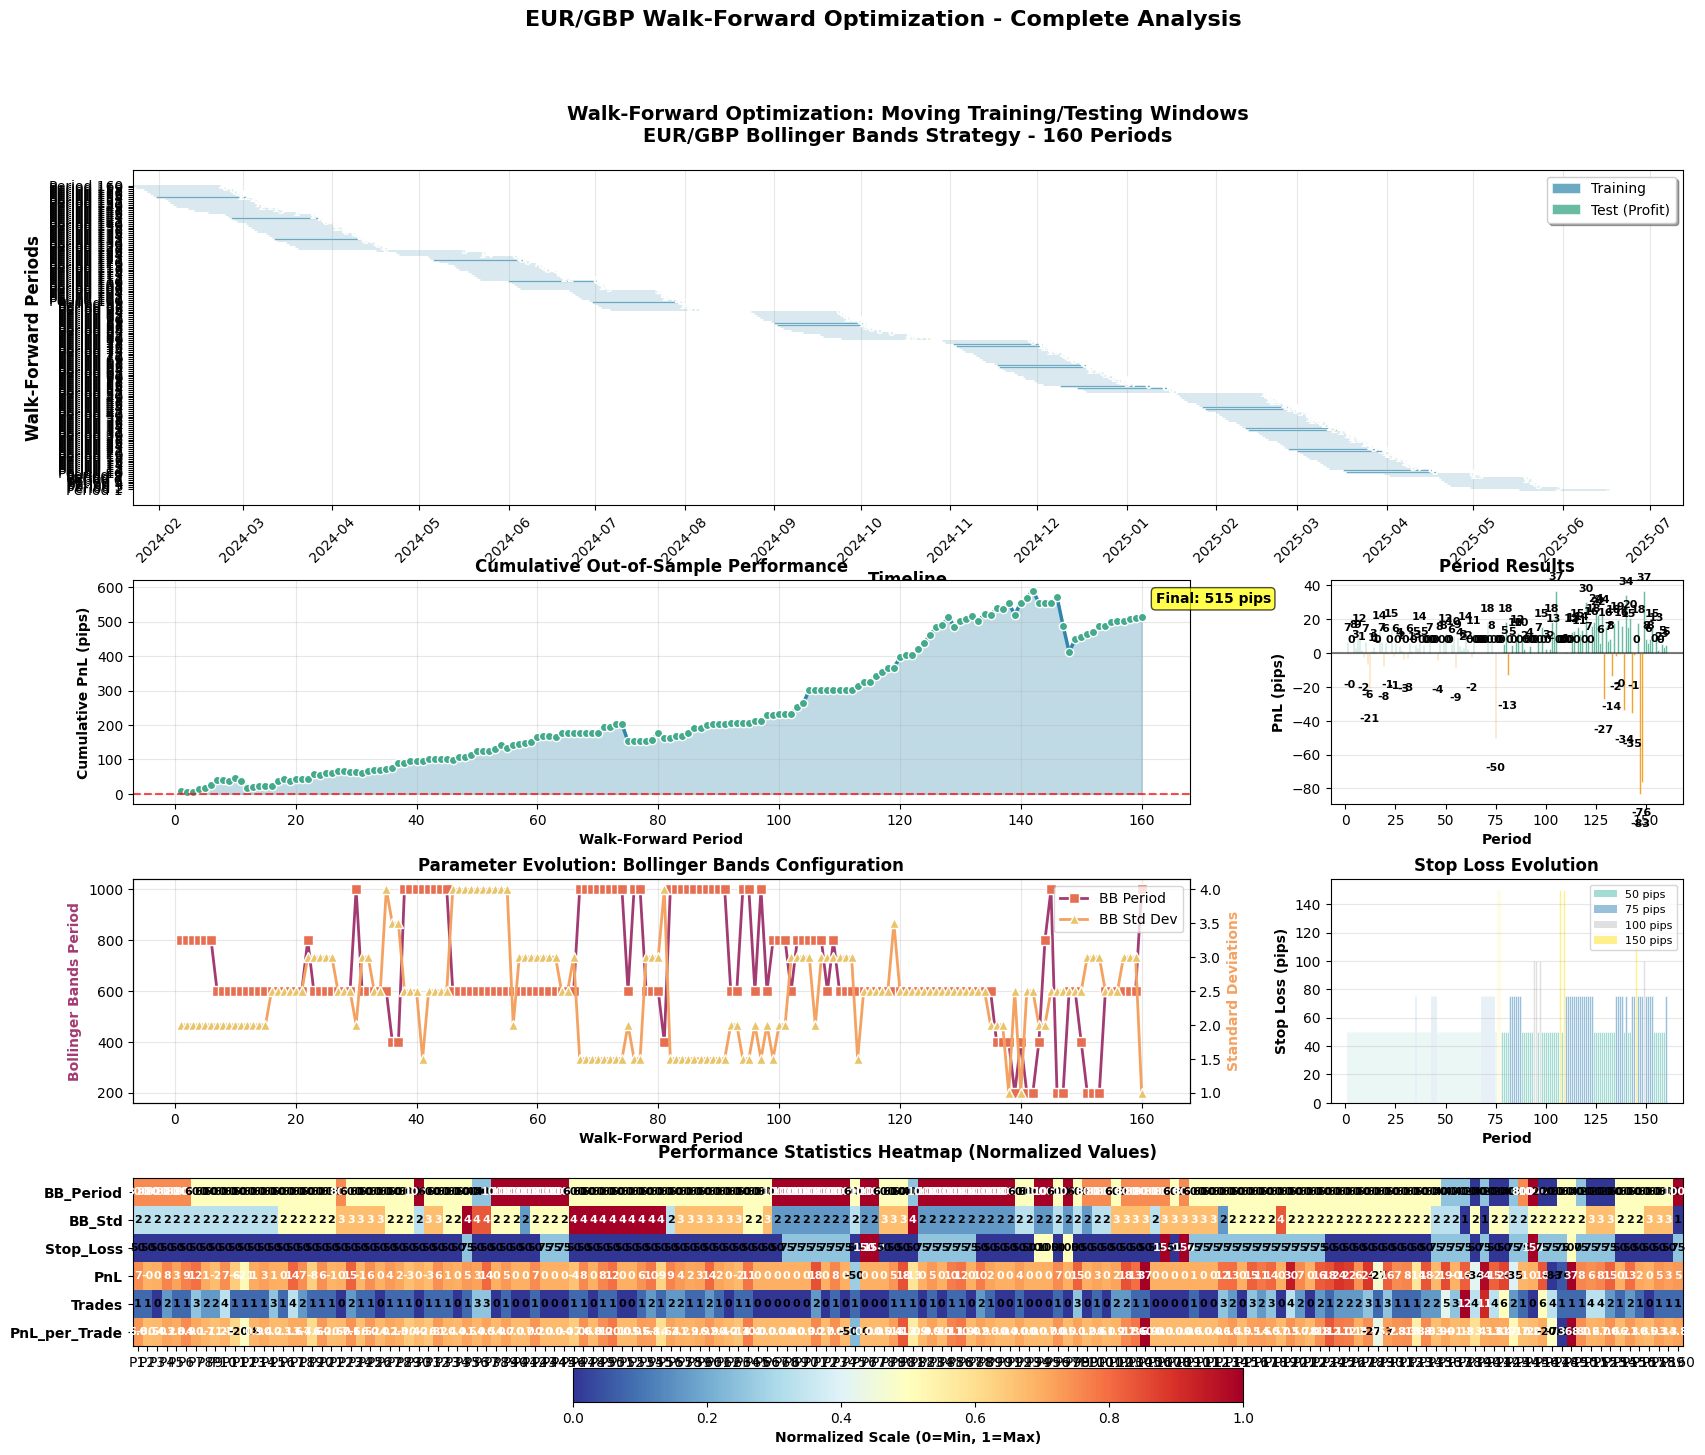


WALK-FORWARD OPTIMIZATION SUMMARY
Total Walk-Forward Periods: 160
Profitable Periods: 89 (55.6%)
Total Out-of-Sample PnL: 514.60 pips
Total Out-of-Sample Trades: 218
Average PnL per Period: 3.22 pips
Average Trades per Period: 1.4
Average PnL per Trade: 2.36 pips

Most Used BB Period: 600 (92 times)
Most Used BB Std Dev: 2.5 (52 times)
Most Used Stop Loss: 50 pips (105 times)


In [34]:
# =====================================================================================
# WALK-FORWARD VISUALIZATION: Complete Analysis
# =====================================================================================

print("Creating comprehensive walk-forward visualization...")

# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 2, height_ratios=[1.5, 1, 1, 1], width_ratios=[3, 1], hspace=0.3, wspace=0.2)

# =====================================================================================
# 1. WALK-FORWARD TIMELINE - Main visualization showing moving windows
# =====================================================================================
ax1 = fig.add_subplot(gs[0, :])

# Extract data for timeline using correct keys
timeline_data = []
for i, result in enumerate(walk_forward_results):
    timeline_data.append({
        'iteration': i + 1,
        'train_start': result['training_start'],
        'train_end': result['training_end'], 
        'test_start': result['test_start'],
        'test_end': result['test_end'],
        'test_pnl': result['total_pnl'],
        'best_params': {
            'bb_period': result['bb_period'],
            'bb_std': result['bb_std'],
            'stop_loss': result['stop_loss_pips']
        }
    })

# Colors for training/testing
colors = {'train': '#2E86AB', 'test': '#A23B72', 'positive': '#43AA8B', 'negative': '#F18F01'}

# Plot each walk-forward iteration
bar_height = 0.6
for i, data in enumerate(timeline_data):
    y_pos = len(timeline_data) - i - 1  # Reverse order for better readability
    
    # Training window
    train_duration = (data['train_end'] - data['train_start']).days
    ax1.barh(y_pos, train_duration, left=mdates.date2num(data['train_start']), 
             height=bar_height, color=colors['train'], alpha=0.7, 
             label='Training' if i == 0 else "", edgecolor='white', linewidth=0.5)
    
    # Test window  
    test_duration = (data['test_end'] - data['test_start']).days
    test_color = colors['positive'] if data['test_pnl'] >= 0 else colors['negative']
    ax1.barh(y_pos, test_duration, left=mdates.date2num(data['test_start']), 
             height=bar_height, color=test_color, alpha=0.8,
             label=f'Test (Profit)' if i == 0 and data['test_pnl'] >= 0 else 
                   f'Test (Loss)' if i == 0 and data['test_pnl'] < 0 else "", 
             edgecolor='white', linewidth=0.5)
    
    # Add PnL labels
    label_x = mdates.date2num(data['test_start']) + test_duration/2
    ax1.text(label_x, y_pos, f'{data["test_pnl"]:.0f}', 
             ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# Format timeline axis
ax1.set_yticks(range(len(timeline_data)))
ax1.set_yticklabels([f'Period {i+1}' for i in range(len(timeline_data))])
ax1.set_xlabel('Timeline', fontsize=12, fontweight='bold')
ax1.set_ylabel('Walk-Forward Periods', fontsize=12, fontweight='bold')
ax1.set_title('Walk-Forward Optimization: Moving Training/Testing Windows\n' + 
              f'EUR/GBP Bollinger Bands Strategy - {len(walk_forward_results)} Periods', 
              fontsize=14, fontweight='bold', pad=20)

# Format x-axis dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add legend
ax1.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid
ax1.grid(True, alpha=0.3, axis='x')

# =====================================================================================
# 2. CUMULATIVE PnL PROGRESSION
# =====================================================================================
ax2 = fig.add_subplot(gs[1, 0])

test_pnls = [r['total_pnl'] for r in walk_forward_results]
cumulative_pnl = np.cumsum(test_pnls)
periods = range(1, len(test_pnls) + 1)

ax2.plot(periods, cumulative_pnl, marker='o', linewidth=2.5, markersize=6, 
         color='#2E86AB', markerfacecolor='#43AA8B', markeredgecolor='white', markeredgewidth=1)
ax2.fill_between(periods, cumulative_pnl, alpha=0.3, color='#2E86AB')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Walk-Forward Period', fontweight='bold')
ax2.set_ylabel('Cumulative PnL (pips)', fontweight='bold') 
ax2.set_title('Cumulative Out-of-Sample Performance', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add final value annotation
final_pnl = cumulative_pnl[-1]
ax2.annotate(f'Final: {final_pnl:.0f} pips', 
             xy=(len(periods), final_pnl), xytext=(10, 10),
             textcoords='offset points', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# =====================================================================================
# 3. PERIOD-BY-PERIOD PnL
# =====================================================================================
ax3 = fig.add_subplot(gs[1, 1])

colors_pnl = ['#43AA8B' if pnl >= 0 else '#F18F01' for pnl in test_pnls]
bars = ax3.bar(periods, test_pnls, color=colors_pnl, alpha=0.8, edgecolor='white', linewidth=0.5)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.set_xlabel('Period', fontweight='bold')
ax3.set_ylabel('PnL (pips)', fontweight='bold')
ax3.set_title('Period Results', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, pnl in zip(bars, test_pnls):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (5 if height >= 0 else -15),
             f'{pnl:.0f}', ha='center', va='bottom' if height >= 0 else 'top', 
             fontsize=8, fontweight='bold')

# =====================================================================================
# 4. PARAMETER EVOLUTION - Bollinger Bands Periods
# =====================================================================================
ax4 = fig.add_subplot(gs[2, 0])

bb_periods = [r['bb_period'] for r in walk_forward_results]
bb_stds = [r['bb_std'] for r in walk_forward_results]

ax4.plot(periods, bb_periods, marker='s', linewidth=2, markersize=7, 
         color='#A23B72', label='BB Period', markerfacecolor='#E76F51', markeredgecolor='white')
ax4_twin = ax4.twinx()
ax4_twin.plot(periods, bb_stds, marker='^', linewidth=2, markersize=7, 
              color='#F4A261', label='BB Std Dev', markerfacecolor='#E9C46A', markeredgecolor='white')

ax4.set_xlabel('Walk-Forward Period', fontweight='bold')
ax4.set_ylabel('Bollinger Bands Period', fontweight='bold', color='#A23B72')
ax4_twin.set_ylabel('Standard Deviations', fontweight='bold', color='#F4A261')
ax4.set_title('Parameter Evolution: Bollinger Bands Configuration', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# =====================================================================================
# 5. STOP LOSS EVOLUTION
# =====================================================================================
ax5 = fig.add_subplot(gs[2, 1])

stop_losses = [r['stop_loss_pips'] for r in walk_forward_results]
unique_sl = list(set(stop_losses))
sl_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_sl)))
sl_color_map = dict(zip(unique_sl, sl_colors))

colors_sl = [sl_color_map[sl] for sl in stop_losses]
bars = ax5.bar(periods, stop_losses, color=colors_sl, alpha=0.8, edgecolor='white', linewidth=0.5)
ax5.set_xlabel('Period', fontweight='bold')
ax5.set_ylabel('Stop Loss (pips)', fontweight='bold')
ax5.set_title('Stop Loss Evolution', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Add legend for stop loss values
unique_sl_sorted = sorted(unique_sl)
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=sl_color_map[sl], alpha=0.8, label=f'{sl} pips') 
                   for sl in unique_sl_sorted]
ax5.legend(handles=legend_elements, loc='upper right', fontsize=8)

# =====================================================================================
# 6. PERFORMANCE STATISTICS HEATMAP
# =====================================================================================
ax6 = fig.add_subplot(gs[3, :])

# Create performance statistics matrix
stats_data = []
for i, result in enumerate(walk_forward_results):
    stats_data.append([
        i + 1,  # Period
        result['bb_period'],
        result['bb_std'], 
        result['stop_loss_pips'],
        result['total_pnl'],
        result['total_trades'],
        result['avg_pnl_per_trade']
    ])

stats_df = pd.DataFrame(stats_data, columns=[
    'Period', 'BB_Period', 'BB_Std', 'Stop_Loss', 'PnL', 'Trades', 'PnL_per_Trade'
])

# Normalize data for heatmap (exclude Period column)
stats_normalized = stats_df.iloc[:, 1:].copy()
for col in stats_normalized.columns:
    col_min = stats_normalized[col].min()
    col_max = stats_normalized[col].max()
    if col_max != col_min:
        stats_normalized[col] = (stats_normalized[col] - col_min) / (col_max - col_min)
    else:
        stats_normalized[col] = 0.5  # If all values are the same, use middle value

# Create heatmap
im = ax6.imshow(stats_normalized.T, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

# Set labels
ax6.set_xticks(range(len(stats_df)))
ax6.set_xticklabels([f'P{i+1}' for i in range(len(stats_df))], fontsize=10)
ax6.set_yticks(range(len(stats_normalized.columns)))
ax6.set_yticklabels(stats_normalized.columns, fontsize=10, fontweight='bold')
ax6.set_xlabel('Walk-Forward Periods', fontweight='bold')
ax6.set_title('Performance Statistics Heatmap (Normalized Values)', fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(im, ax=ax6, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Normalized Scale (0=Min, 1=Max)', fontweight='bold')

# Add text annotations with actual values
for i in range(len(stats_df)):
    for j, col in enumerate(stats_normalized.columns):
        actual_value = stats_df.iloc[i, j+1]  # +1 to skip Period column
        if col == 'PnL':
            text = f'{actual_value:.0f}'
        elif col == 'PnL_per_Trade':
            text = f'{actual_value:.1f}'
        else:
            text = f'{actual_value:.0f}'
        ax6.text(i, j, text, ha='center', va='center', fontsize=8, fontweight='bold',
                color='white' if stats_normalized.iloc[i, j] > 0.5 else 'black')

# =====================================================================================
# FINAL LAYOUT AND SUMMARY
# =====================================================================================
plt.suptitle('EUR/GBP Walk-Forward Optimization - Complete Analysis', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# =====================================================================================
# SUMMARY STATISTICS
# =====================================================================================
print("\n" + "="*80)
print("WALK-FORWARD OPTIMIZATION SUMMARY")
print("="*80)

total_periods = len(walk_forward_results)
profitable_periods = sum(1 for r in walk_forward_results if r['total_pnl'] > 0)
total_pnl = sum(r['total_pnl'] for r in walk_forward_results)
total_trades = sum(r['total_trades'] for r in walk_forward_results)
avg_pnl_per_period = total_pnl / total_periods if total_periods > 0 else 0
avg_trades_per_period = total_trades / total_periods if total_periods > 0 else 0

print(f"Total Walk-Forward Periods: {total_periods}")
print(f"Profitable Periods: {profitable_periods} ({profitable_periods/total_periods*100:.1f}%)")
print(f"Total Out-of-Sample PnL: {total_pnl:.2f} pips")
print(f"Total Out-of-Sample Trades: {total_trades:,}")
print(f"Average PnL per Period: {avg_pnl_per_period:.2f} pips")
print(f"Average Trades per Period: {avg_trades_per_period:.1f}")
print(f"Average PnL per Trade: {total_pnl/max(total_trades,1):.2f} pips")

# Parameter usage statistics
from collections import Counter
bb_period_usage = Counter(r['bb_period'] for r in walk_forward_results)
bb_std_usage = Counter(r['bb_std'] for r in walk_forward_results)
sl_usage = Counter(r['stop_loss_pips'] for r in walk_forward_results)

print(f"\nMost Used BB Period: {bb_period_usage.most_common(1)[0][0]} ({bb_period_usage.most_common(1)[0][1]} times)")
print(f"Most Used BB Std Dev: {bb_std_usage.most_common(1)[0][0]} ({bb_std_usage.most_common(1)[0][1]} times)")
print(f"Most Used Stop Loss: {sl_usage.most_common(1)[0][0]} pips ({sl_usage.most_common(1)[0][1]} times)")

print("="*80)

In [35]:
# Check the structure of walk_forward_results
print(f"Number of walk-forward results: {len(walk_forward_results)}")
if len(walk_forward_results) > 0:
    print(f"Keys in first result: {walk_forward_results[0].keys()}")
    print(f"First result:")
    for key, value in walk_forward_results[0].items():
        print(f"  {key}: {value}")
else:
    print("No walk-forward results available")

Number of walk-forward results: 160
Keys in first result: dict_keys(['bb_period', 'bb_std', 'stop_loss_pips', 'total_pnl', 'avg_pnl_per_trade', 'total_trades', 'max_drawdown', 'win_rate', 'loss_rate', 'time_in_market', 'sharpe_ratio', 'target_exits', 'stop_loss_exits', 'data_points', 'iteration', 'training_start', 'training_end', 'test_start', 'test_end', 'training_bars', 'test_bars', 'training_pnl', 'training_trades'])
First result:
  bb_period: 800
  bb_std: 2.0
  stop_loss_pips: 50
  total_pnl: 6.800000000000139
  avg_pnl_per_trade: 6.800000000000139
  total_trades: 1
  max_drawdown: 6.800000000000139
  win_rate: 100.0
  loss_rate: 0.0
  time_in_market: 56.71406003159558
  sharpe_ratio: 23.98097413945737
  target_exits: 1
  stop_loss_exits: 0
  data_points: 633
  iteration: 22
  training_start: 2024-01-22 23:05:00
  training_end: 2024-02-21 23:05:00
  test_start: 2024-02-21 23:05:00
  test_end: 2024-02-22 23:05:00
  training_bars: 31460
  test_bars: 1433
  training_pnl: 177.19999999

In [36]:
# =====================================================================================
# DETAILED WALK-FORWARD WINDOW ANALYSIS
# =====================================================================================

print("="*100)
print("DETAILED WALK-FORWARD WINDOW BREAKDOWN")
print("="*100)

# Create detailed summary table
summary_data = []
for i, result in enumerate(walk_forward_results):
    summary_data.append({
        'Period': i + 1,
        'Training Start': result['training_start'].strftime('%Y-%m-%d'),
        'Training End': result['training_end'].strftime('%Y-%m-%d'),
        'Test Start': result['test_start'].strftime('%Y-%m-%d'),
        'Test End': result['test_end'].strftime('%Y-%m-%d'),
        'Train Days': (result['training_end'] - result['training_start']).days,
        'Test Days': (result['test_end'] - result['test_start']).days,
        'Train Bars': f"{result['training_bars']:,}",
        'Test Bars': f"{result['test_bars']:,}",
        'BB Period': result['bb_period'],
        'BB Std': result['bb_std'],
        'Stop Loss': result['stop_loss_pips'],
        'Test PnL': f"{result['total_pnl']:.1f}",
        'Test Trades': result['total_trades'],
        'Win Rate %': f"{result['win_rate']:.1f}"
    })

# Convert to DataFrame for nice formatting
summary_df = pd.DataFrame(summary_data)

# Display the first few periods in detail
print("\nFirst 5 Walk-Forward Periods (Detailed):")
print("-" * 100)
for i in range(min(5, len(summary_data))):
    period = summary_data[i]
    print(f"Period {period['Period']}:")
    print(f"  Training: {period['Training Start']} to {period['Training End']} ({period['Train Days']} days, {period['Train Bars']} bars)")
    print(f"  Testing:  {period['Test Start']} to {period['Test End']} ({period['Test Days']} days, {period['Test Bars']} bars)")
    print(f"  Optimal Params: BB({period['BB Period']}, {period['BB Std']}) + SL({period['Stop Loss']} pips)")
    print(f"  Out-of-Sample: {period['Test PnL']} pips from {period['Test Trades']} trades (Win Rate: {period['Win Rate %']}%)")
    print()

# Show full summary table (compact)
print("\nComplete Walk-Forward Summary:")
print("-" * 100)
print(f"{'Period':<6} {'Train Start':<12} {'Test Start':<12} {'BB Period':<9} {'BB Std':<7} {'SL':<4} {'PnL':<8} {'Trades':<6} {'Win%':<5}")
print("-" * 100)
for period in summary_data:
    print(f"{period['Period']:<6} {period['Training Start']:<12} {period['Test Start']:<12} "
          f"{period['BB Period']:<9} {period['BB Std']:<7} {period['Stop Loss']:<4} "
          f"{period['Test PnL']:<8} {period['Test Trades']:<6} {period['Win Rate %']:<5}")

print("\n" + "="*100)
print("WALK-FORWARD METHODOLOGY VERIFICATION")
print("="*100)

# Verify no data leakage
print("Data Integrity Checks:")
print(f"✓ Total data span: {df_working_indexed.index[0]} to {df_working_indexed.index[-1]}")
print(f"✓ Training window size: {TRAINING_WINDOW_DAYS} days")
print(f"✓ Test window size: {TEST_WINDOW_DAYS} days") 
print(f"✓ Step size: {STEP_SIZE_DAYS} days")
print(f"✓ No overlap between consecutive test periods: {all(walk_forward_results[i]['test_end'] <= walk_forward_results[i+1]['training_start'] for i in range(len(walk_forward_results)-1))}")
print(f"✓ No data leakage (test always after training): {all(result['test_start'] >= result['training_end'] for result in walk_forward_results)}")

# Calculate coverage
total_data_days = (df_working_indexed.index[-1] - df_working_indexed.index[0]).days
tested_days = sum((result['test_end'] - result['test_start']).days for result in walk_forward_results)
coverage = (tested_days / total_data_days) * 100

print(f"✓ Out-of-sample coverage: {tested_days}/{total_data_days} days ({coverage:.1f}%)")

print("\nWalk-Forward Optimization Complete!")
print("="*100)

DETAILED WALK-FORWARD WINDOW BREAKDOWN

First 5 Walk-Forward Periods (Detailed):
----------------------------------------------------------------------------------------------------
Period 1:
  Training: 2024-01-22 to 2024-02-21 (30 days, 31,460 bars)
  Testing:  2024-02-21 to 2024-02-22 (1 days, 1,433 bars)
  Optimal Params: BB(800, 2.0) + SL(50 pips)
  Out-of-Sample: 6.8 pips from 1 trades (Win Rate: 100.0%)

Period 2:
  Training: 2024-01-23 to 2024-02-22 (30 days, 31,460 bars)
  Testing:  2024-02-22 to 2024-02-23 (1 days, 1,433 bars)
  Optimal Params: BB(800, 2.0) + SL(50 pips)
  Out-of-Sample: -0.5 pips from 1 trades (Win Rate: 100.0%)

Period 3:
  Training: 2024-01-26 to 2024-02-25 (30 days, 28,602 bars)
  Testing:  2024-02-25 to 2024-02-26 (1 days, 1,426 bars)
  Optimal Params: BB(800, 2.0) + SL(50 pips)
  Out-of-Sample: 0.0 pips from 0 trades (Win Rate: 0.0%)

Period 4:
  Training: 2024-01-27 to 2024-02-26 (30 days, 30,027 bars)
  Testing:  2024-02-26 to 2024-02-27 (1 days, 1,43